# MrVI analysis over Tahoe100M cells dataset

MrVI (Multi-resolution Variational Inference) is a model for analyzing multi-sample single-cell RNA-seq data. 
This tutorial show how to do run MrVI in PyTorch version over the [Tahoe100M](https://doi.org/10.1101/2025.02.20.639398) cells dataset and perform basic analysis.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import scvi.hub
import seaborn as sns
import torch
from scvi.external import MRVI

run_autotune = False

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.0 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


In [3]:
# import inspect
# print(inspect.getsource(MRVI))

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [6]:
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)

## Get the data

We start by downloading the model from its hub in order to use its metadata
Note that the model is very large therefore it will take time to being download.

In [7]:
# get the hub data
tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(
    repo_name="vevotx/Tahoe-100M-SCVI-v1", cache_dir="."
)

/tmp/ipykernel_1545918/472539365.py:2: UserWarning: No revision was passed, so the default (latest) revision will be used.
  tahoe_hubmodel = scvi.hub.HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

adata.h5ad:   0%|          | 0.00/42.4G [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

_scvi_required_metadata.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

In [8]:
tahoe_hubmodel.model.adata.obs.head()

INFO     Loading model...                                                                                          
INFO     File ./models--vevotx--Tahoe-100M-SCVI-v1/snapshots/b5283a73fbbed812a95264ace360da538b20af89/model.pt     
         already downloaded                                                                                        


sample species  gene_count  tscp_count  mread_count  bc1_wind  bc2_wind  bc3_wind bc1_well bc2_well bc3_well                 id                     drugname_drugconc                drug  INT_ID  NUM.SNPS  NUM.READS demuxlet_call  BEST.LLK  NEXT.LLK  DIFF.LLK.BEST.NEXT  BEST.POSTERIOR  SNG.POSTERIOR  SNG.BEST.LLK  SNG.NEXT.LLK  SNG.ONLY.POSTERIOR  DBL.BEST.LLK  DIFF.LLK.SNG.DBL sublibrary     BARCODE  pcnt_mito   S_score  G2M_score phase pass_filter dataset  _scvi_batch  _scvi_labels  _scvi_observed_lib_size plate Cell_Name_Vevo Cell_ID_Cellosaur  observed_lib_size
BARCODE_SUB_LIB_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
01_001_052-lib_1105  smp_1783    hg38        1878        2893         3284         1         1        52       A1       A1       E4  recgIHRi9MiCIr4CO  [('8-Hydroxyquinoline', 0.05, 'uM')]  8-Hydroxyquinoline     1.0     199.0      215.0       singlet    -50.74    -59.04                8.30           -55.0            1.0        -50.74        -87.96                 0.0        -59.04              8.30   lib_1105  01_001_052   0.019357  0.174603   0.179670   G2M        full       0            0             0                     2893     4         PANC-1         CVCL_0480               2893
01_001_105-lib_1105  smp_1783    hg38        1765        2434         2764         1         1       105       A1       A1    p2.A9  recgIHRi9MiCIr4CO  [('8-Hydroxyquinoline', 0.05, 'uM')]  8-Hydroxyquinoline     3.0     137.0      140.0       singlet    -37.97    -42.41                4.44           -43.0            1.0        -37.97        -64.52                 0.0        -42.41              4.44   lib_1105  01_001_105   0.029581  0.297619   0.342857   G2M        full       0            0             0                     2434     4          SW480         CVCL_0546               2434
01_001_165-lib_1105  smp_1783    hg38        3174        5691         6454         1         1       165       A1       A1    p2.F9  recgIHRi9MiCIr4CO  [('8-Hydroxyquinoline', 0.05, 'uM')]  8-Hydroxyquinoline     4.0     379.0      396.0       singlet   -129.66   -130.65                0.99          -130.0            1.0       -129.66       -186.89                 0.0       -130.65              0.99   lib_1105  01_001_165   0.031629  0.031746   0.099084   G2M        full       0            0             0                     5691     4         SW1417         CVCL_1717               5691
01_003_094-lib_1105  smp_1783    hg38        1380        1804         2050         1         3        94       A1       A3      H10  recgIHRi9MiCIr4CO  [('8-Hydroxyquinoline', 0.05, 'uM')]  8-Hydroxyquinoline     7.0     122.0      125.0       singlet    -31.79    -33.98                2.19           -36.0            1.0        -31.79        -49.36                 0.0        -33.98              2.19   lib_1105  01_003_094   0.017738 -0.063492   0.019780   G2M        full       0            0             0                     1804     4         SW1417         CVCL_1717               1804
01_003_164-lib_1105  smp_1783    hg38        1179        1514         1715         1         3       164       A1       A3    p2.F8  recgIHRi9MiCIr4CO  [('8-Hydroxyquinoline', 0.05, 'uM')]  8-Hydroxyquinoline     8.0      87.0       93.0       singlet    -28.99    -27.07               -1.92           -34.0            1.0        -28.99        -41.61                 0.0        -27.07             -1.92   lib_1105  01_003_164   0.023118 -0.075397  -0.070879  

In [9]:
# Load Cell Line Metadata
cell_lines = pd.read_csv(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/cell_line_metadata.h5ad"
)
cell_lines.head()

Unnamed: 0 cell_name Cell_ID_DepMap Cell_ID_Cellosaur Organ Driver_Gene_Symbol Driver_VarZyg Driver_VarType Driver_ProtEffect_or_CdnaEffect Driver_Mech_InferDM Driver_GeneType_DM
0           0      A549     ACH-000681         CVCL_0023  Lung             CDKN2A           Hom       Deletion                             DEL                 LoF         Suppressor
1           1      A549     ACH-000681         CVCL_0023  Lung             CDKN2B           Hom       Deletion                             DEL                 LoF         Suppressor
2           2      A549     ACH-000681         CVCL_0023  Lung               KRAS           Hom       Missense                          p.G12S                 GoF           Oncogene
3           3      A549     ACH-000681         CVCL_0023  Lung            SMARCA4           Hom     Frameshift                        p.Q729fs                 LoF         Suppressor
4           4      A549     ACH-000681         CVCL_0023  Lung              STK11           Hom       Stopgain                          p.Q37*                 LoF         Suppressor

In [10]:
# Load the .h5ad file
adata = sc.read_h5ad(
    "/home/access/PycharmProjects/scvi-tools/Tahoe100M/tahoe100m_sample_100000_rand.h5ad"
)
adata.obs.head()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


drug    sample   BARCODE_SUB_LIB_ID cell_line_id                   moa-fine                                   canonical_smiles pubchem_cid   plate  mean_gene_count  mean_tscp_count  mean_mread_count  mean_pcnt_mito                       drugname_drugconc           targets             moa-broad human-approved clinical-trials                                 gpt-notes-approval
0  Niclosamide (olamine)  smp_2257  91_109_060-lib_2401    CVCL_1577                    unclear  C1=CC(=C(C=C1[N+](=O)[O-])Cl)NC(=O)C2=C(C=CC(=...     14992.0  plate8      1553.713059      2518.258820       2984.088782        0.037475  [('Niclosamide (olamine)', 0.5, 'uM')]             STAT3  inhibitor/antagonist            yes             yes  Approved for parasitic infections, investigate...
1             Peretinoin  smp_2258  92_149_042-lib_2401    CVCL_0504  Retinoic receptor agonist             CC(=CCCC(=CCCC(=CC=CC(=CC(=O)O)C)C)C)C   6437836.0  plate8      1588.514329      2725.711632       3232.796996        0.085470             [('Peretinoin', 0.5, 'uM')]  RXRA, RXRB, RXRG               unclear             no             yes  Studied for liver cancer, not approved for hum...
2             Peretinoin  smp_2258  92_101_110-lib_2401    CVCL_0459  Retinoic receptor agonist             CC(=CCCC(=CCCC(=CC=CC(=CC(=O)O)C)C)C)C   6437836.0  plate8      1588.514329      2725.711632       3232.796996        0.085470             [('Peretinoin', 0.5, 'uM')]  RXRA, RXRB, RXRG               unclear             no             yes  Studied for liver cancer, not approved for hum...
3  Niclosamide (olamine)  smp_2257  91_187_166-lib_2401    CVCL_0366                    unclear  C1=CC(=C(C=C1[N+](=O)[O-])Cl)NC(=O)C2=C(C=CC(=...     14992.0  plate8      1553.713059      2518.258820       2984.088782        0.037475  [('Niclosamide (olamine)', 0.5, 'uM')]             STAT3  inhibitor/antagonist            yes             yes  Approved for parasitic infections, investigate...
4  Niclosamide (olamine)  smp_2257  91_186_141-lib_2401    CVCL_0504                    unclear  C1=CC(=C(C=C1[N+](=O)[O-])Cl)NC(=O)C2=C(C=CC(=...     14992.0  plate8      1553.713059      2518.258820       2984.088782        0.037475  [('Niclosamide (olamine)', 0.5, 'uM')]             STAT3  inhibitor/antagonist            yes             yes  Approved for parasitic infections, investigate...

We use a subset of data, show the plates stratification and perform HVG filtering following by merging the metadata and split to train and test

In [11]:
adata.obs.plate.value_counts()

plate
plate4    28225
plate8    28225
plate3    28224
plate7    15326
Name: count, dtype: int64

In [12]:
# HVG filtering
sc.pp.highly_variable_genes(
    adata, n_top_genes=15000, inplace=True, subset=True, flavor="seurat_v3", batch_key="plate"
)
adata

AnnData object with n_obs × n_vars = 100000 × 15000
    obs: 'drug', 'sample', 'BARCODE_SUB_LIB_ID', 'cell_line_id', 'moa-fine', 'canonical_smiles', 'pubchem_cid', 'plate', 'mean_gene_count', 'mean_tscp_count', 'mean_mread_count', 'mean_pcnt_mito', 'drugname_drugconc', 'targets', 'moa-broad', 'human-approved', 'clinical-trials', 'gpt-notes-approval'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'

In [13]:
# merge metadata
adata.obs = adata.obs.merge(
    tahoe_hubmodel.model.adata.obs[
        [
            "Cell_Name_Vevo",
            "dataset",
            "phase",
            "observed_lib_size",
            "S_score",
            "G2M_score",
            "sublibrary",
        ]
    ],
    how="left",
    left_on="BARCODE_SUB_LIB_ID",
    right_index=True,
)

In [14]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [15]:
from sklearn.model_selection import train_test_split

train_ind, valid_ind = train_test_split(
    adata.obs.plate.index.astype(int), test_size=0.9, stratify=adata.obs.plate
)

### Init the model

We will initialize the MRVI model with its "pytorch" backend. A JAX backend version can be also be used using backend="jax".

In [16]:
sample_key = "sample"  # target covariate sample/cell_line_id
batch_key = "plate"  # nuisance variable identifier
MRVI.setup_anndata(adata, sample_key=sample_key, batch_key=batch_key, layer="counts", backend="torch")

## Train mrVI

In [17]:
import gc
import time

gc.collect()
start = time.time()
model = MRVI(adata, backend="torch")
model.train(
    max_epochs=400,
    early_stopping=True,
    plan_kwargs={"lr": 1e-3, "n_epochs_kl_warmup": 40},
    batch_size=512,
    early_stopping_patience=5,
    check_val_every_n_epoch=1,
    datasplitter_kwargs={"external_indexing": [np.array(train_ind), np.array(valid_ind)]},
)
end = time.time()
print(f"Elapsed time: {end - start:.2f} seconds")

/tmp/ipykernel_1545918/3637733129.py:6: DeprecationWarning: You are using the Torch Version of MrVI, starting v1.5, This will become the default version of MrVI (and will be renamed to simply: MRVI) and the Jax version will become external
  model = MRVI(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 5 records. Best score: 1306.802. Signaling Trainer to stop.
Elapsed time: 289.82 seconds


In [18]:
train_ind

Index([12671, 38287, 63621, 80870,  1403, 26510, 88553, 19564, 38816, 33316,
       ...
       41111, 87852, 54111, 79936, 61032,  1657, 72773, 28364, 96382, 16134], dtype='int64', length=10000)

In [19]:
valid_ind

Index([37550, 90863, 33241, 24035, 10737, 21757, 92804, 99954, 43105, 33898,
       ...
       74013, 65779, 83502, 95378,  2676, 88516, 70633, 13290, 17217,  2395], dtype='int64', length=90000)

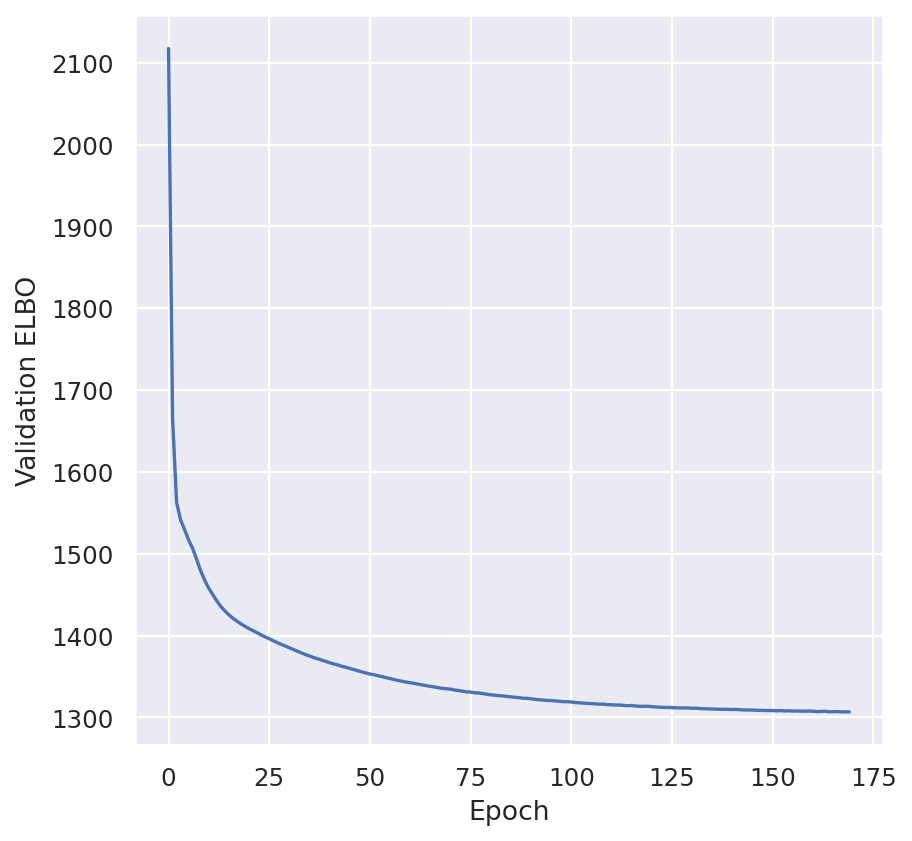

In [20]:
plt.plot(model.history["elbo_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

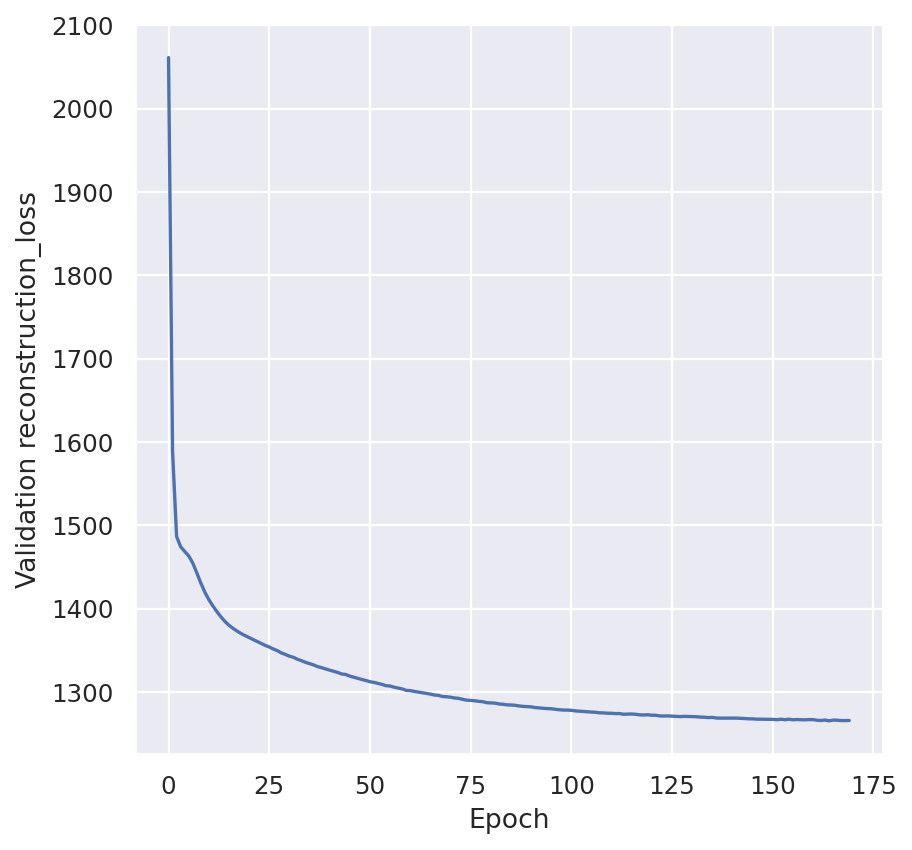

In [21]:
plt.plot(model.history["reconstruction_loss_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation reconstruction_loss")
plt.show()

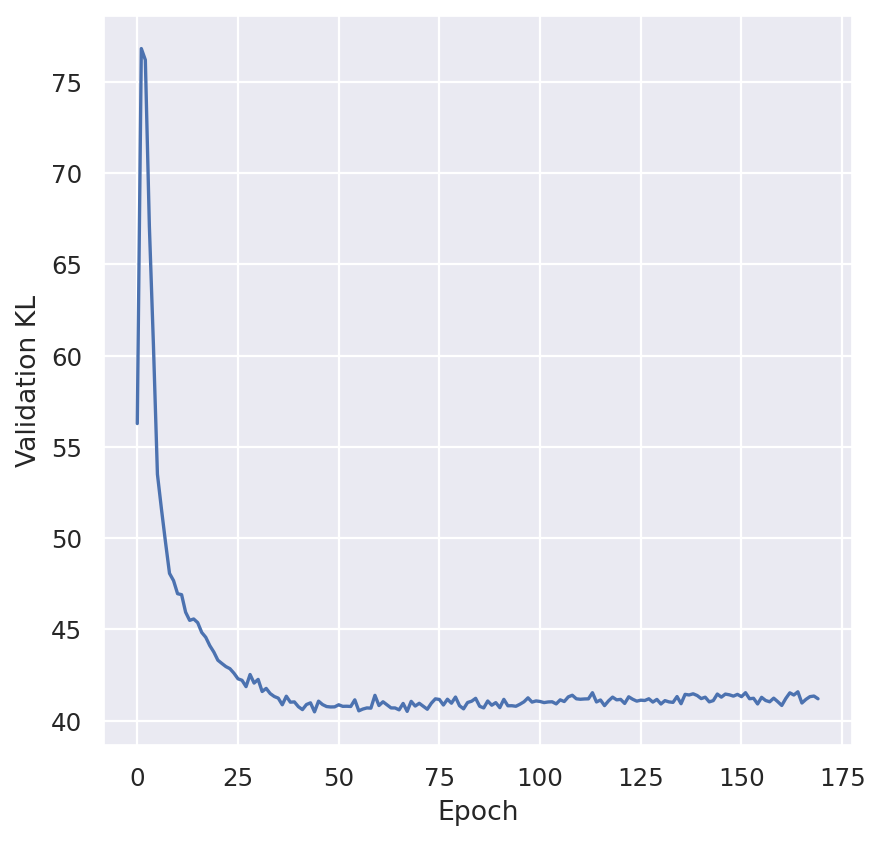

In [22]:
plt.plot(model.history["kl_local_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation KL")
plt.show()

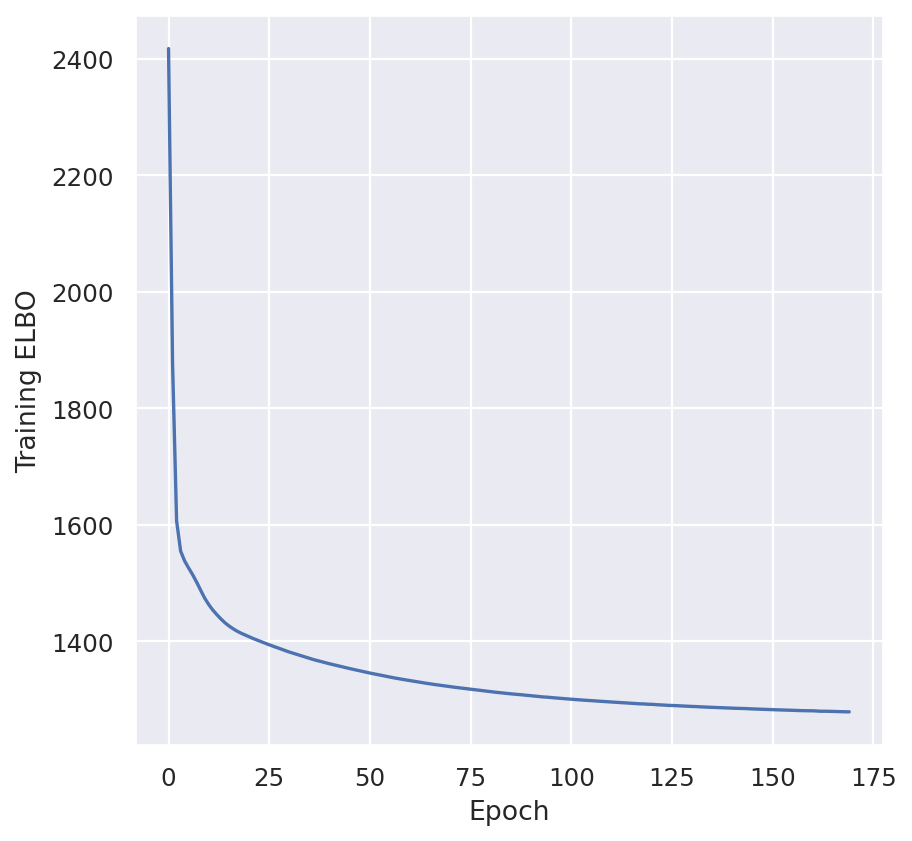

In [23]:
plt.plot(model.history["elbo_train"])
plt.xlabel("Epoch")
plt.ylabel("Training ELBO")
plt.show()

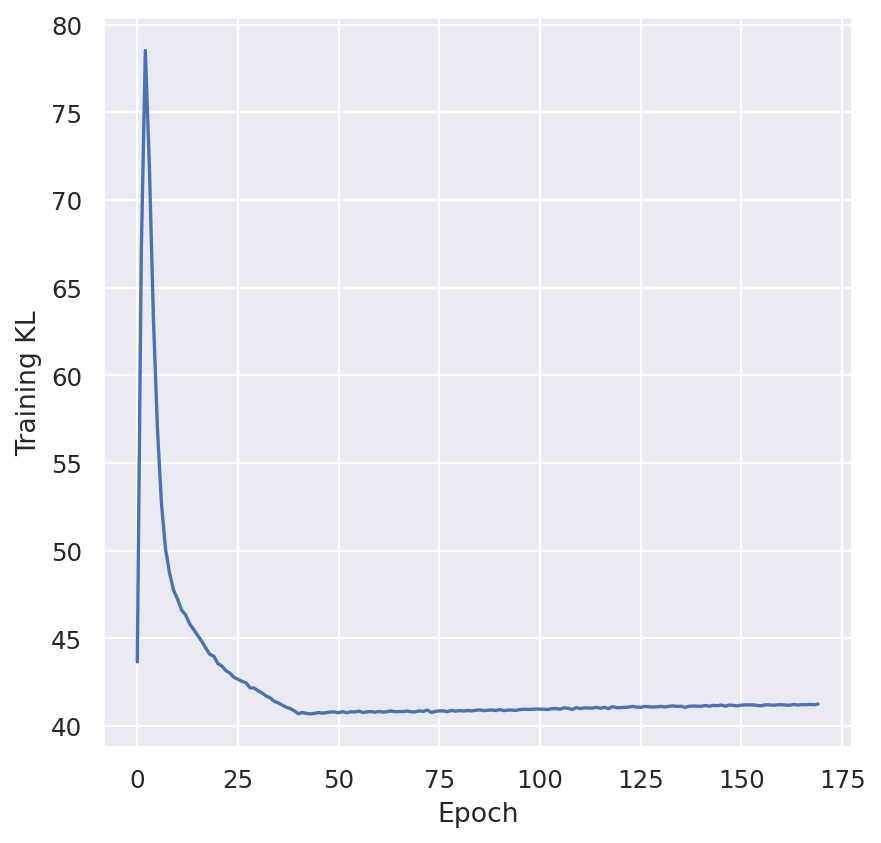

In [24]:
plt.plot(model.history["kl_local_train"])
plt.xlabel("Epoch")
plt.ylabel("Training KL")
plt.show()

## Visualize cell embeddings and sample distances

The latent representations of the cells can also be accessed and visualized using the get_latent_representation method. MrVI learns two latent representations: u and z. u is designed to capture broad cell states invariant to sample and nuisance covariates, while z augments u with sample-specific effects but remains corrected for nuisance covariate effects.


In [25]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=50, n_neighbors=50)
sc.tl.umap(adata, min_dist=0.1)

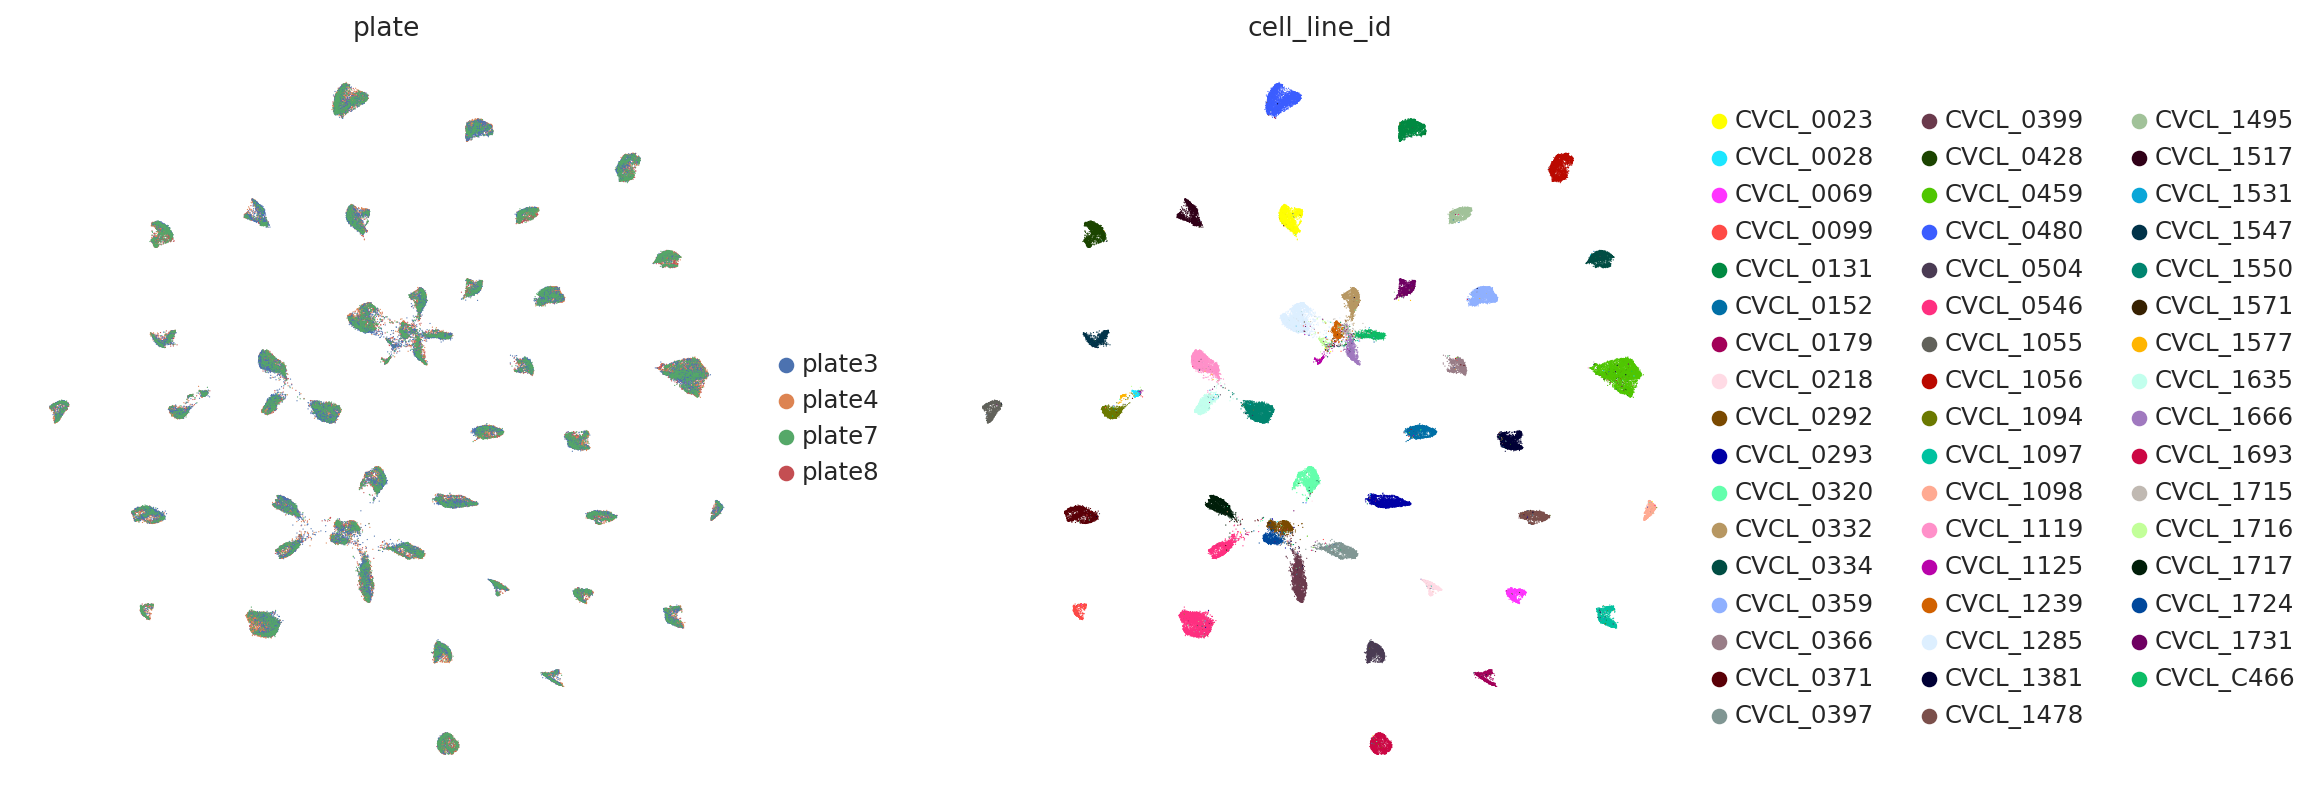

In [26]:
sc.pl.umap(
    adata,
    color=["plate", "cell_line_id"],
    ncols=2,
    frameon=False,
)

In [27]:
u = model.get_latent_representation()
adata.obsm["X_mrVI_Torch"] = u
sc.pp.neighbors(adata, use_rep="X_mrVI_Torch")
sc.tl.umap(adata, min_dist=0.3)

In [28]:
u.shape

(100000, 10)

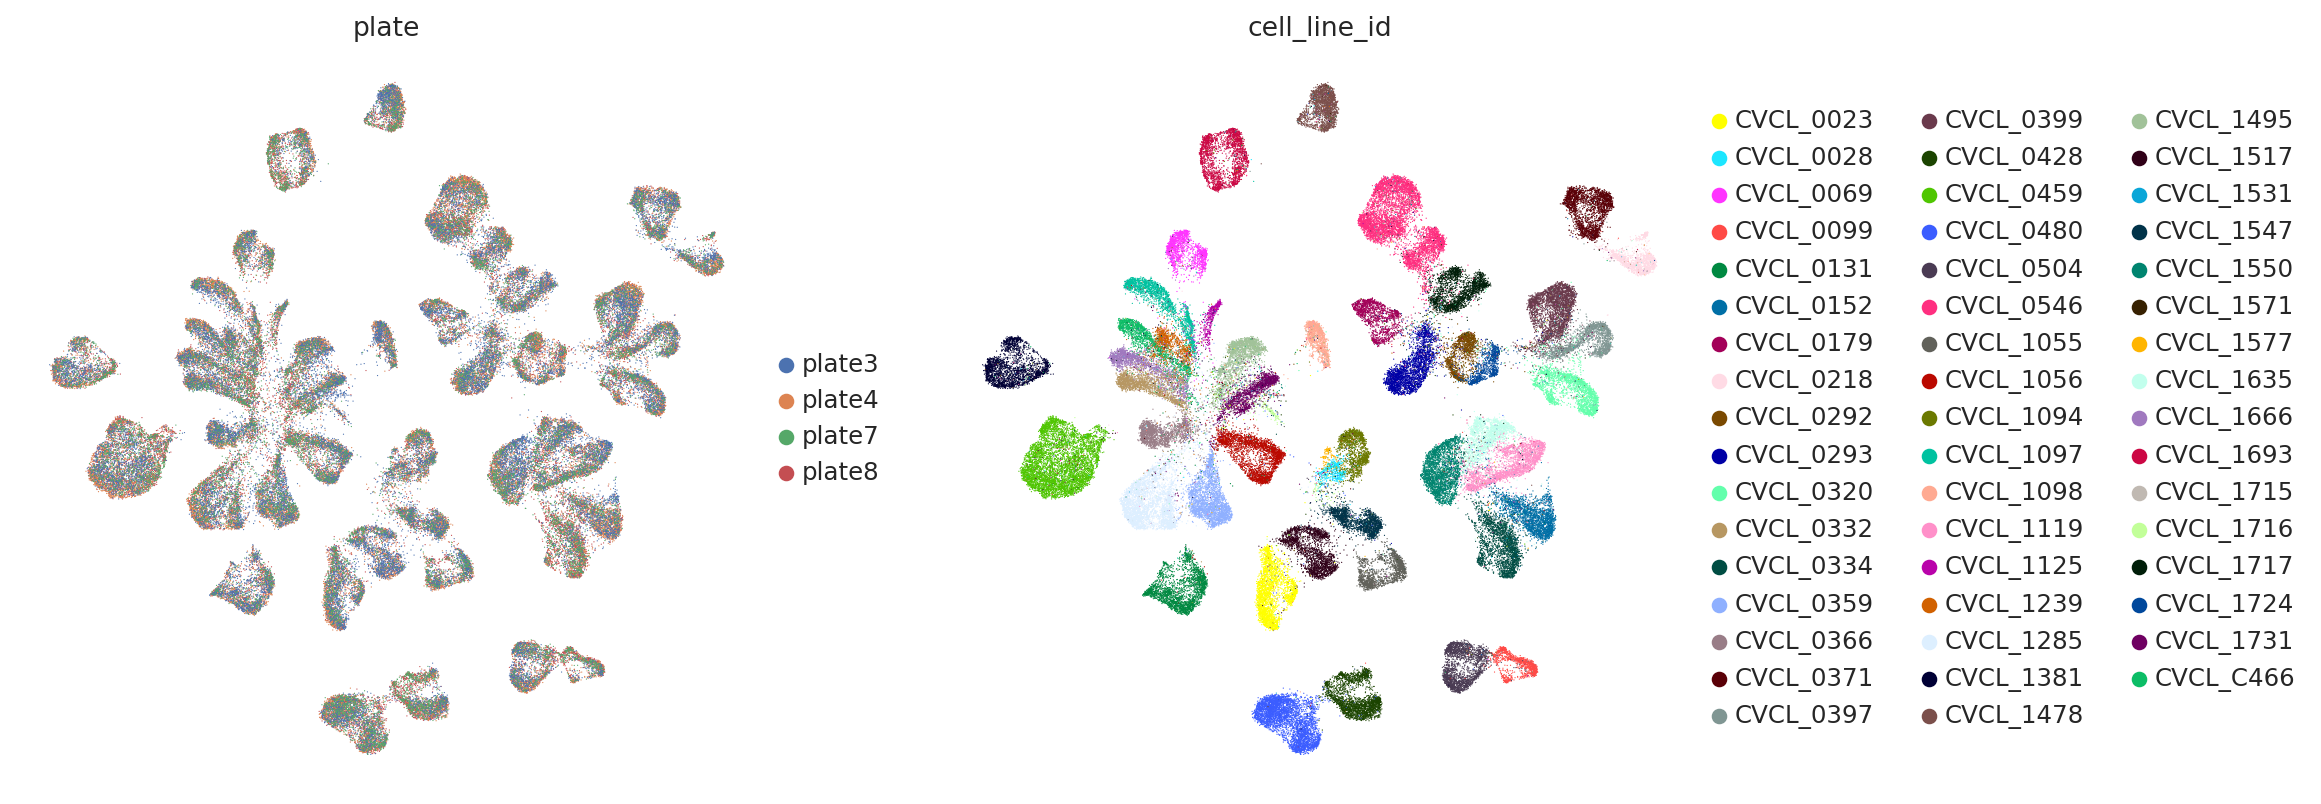

In [29]:
sc.pl.umap(
    adata,
    color=["plate", "cell_line_id"],
    frameon=False,
    ncols=2,
)

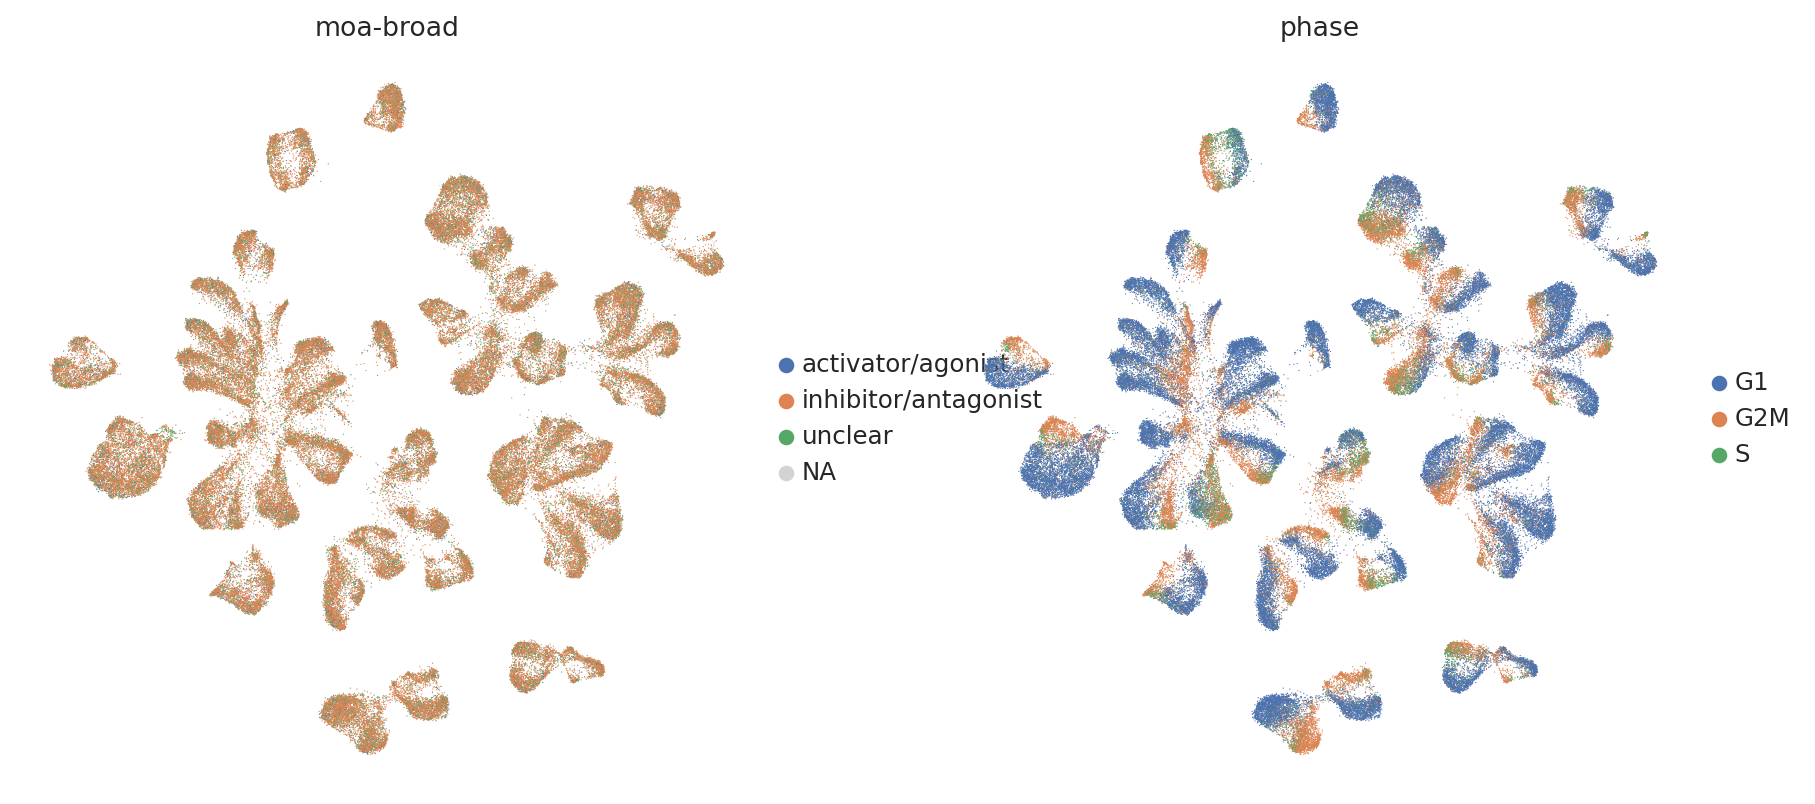

In [30]:
sc.pl.umap(
    adata,
    color=["moa-broad", "phase"],
    frameon=False,
    ncols=2,
)

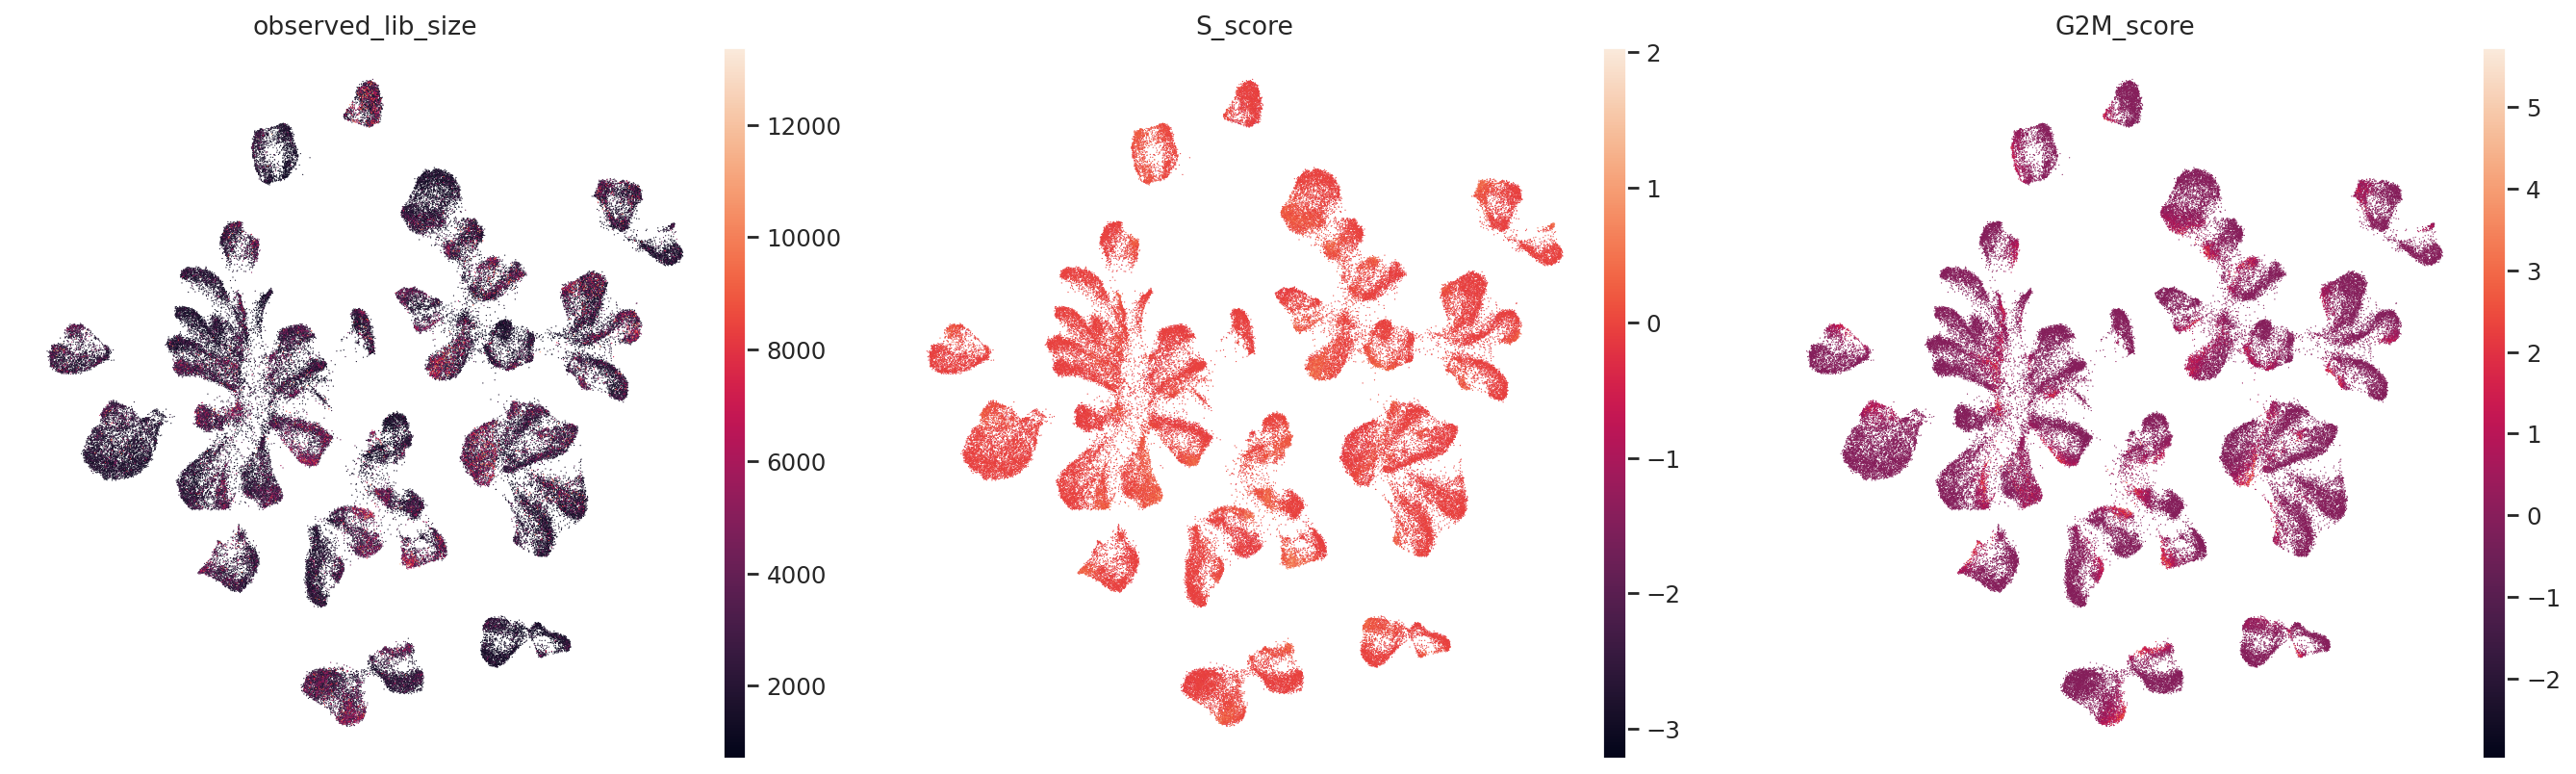

In [31]:
sc.pl.umap(
    adata,
    color=["observed_lib_size", "S_score", "G2M_score"],
    frameon=False,
    ncols=3,
)

## Train regular SCVI model for comparison

In [32]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key=batch_key)

In [33]:
model_scvi = scvi.model.SCVI(adata)

In [34]:
model_scvi.train(
    max_epochs=100,
    early_stopping=True,
    check_val_every_n_epoch=1,
    datasplitter_kwargs={"external_indexing": [np.array(train_ind), np.array(valid_ind)]},
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


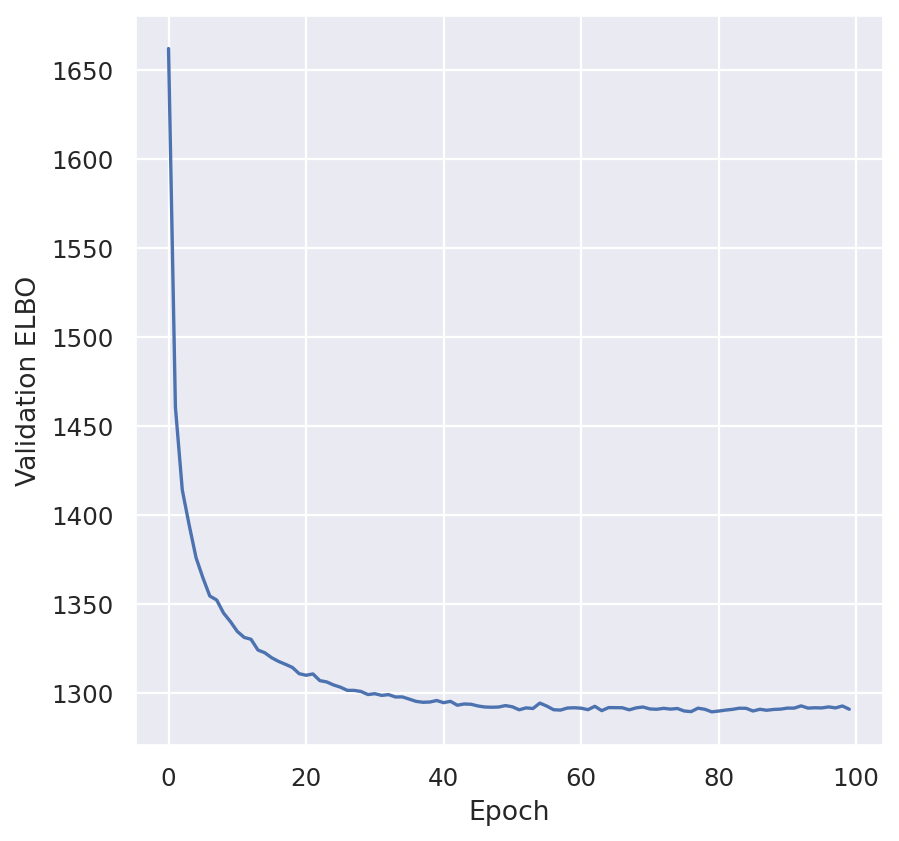

In [35]:
plt.plot(model_scvi.history["elbo_validation"])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

In [36]:
SCVI_LATENT_KEY = "X_scVI"
latent = model_scvi.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(100000, 10)

In [37]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

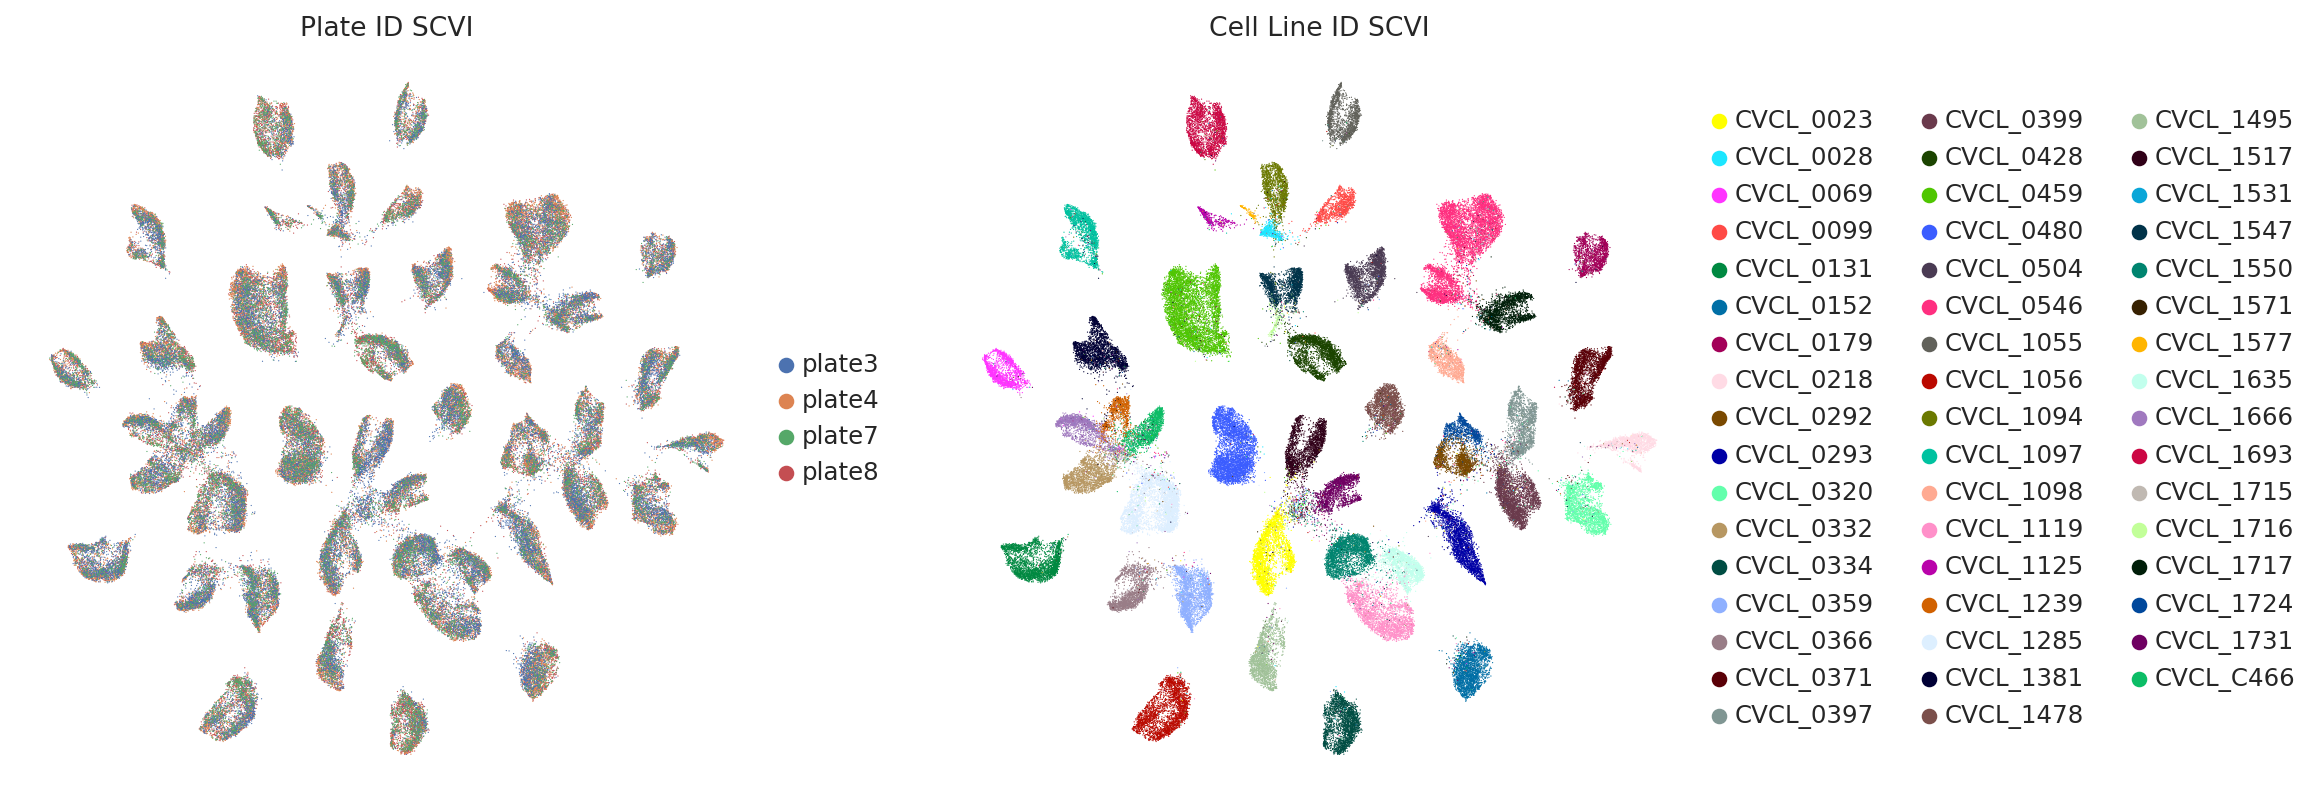

In [38]:
sc.pl.umap(
    adata,
    color=["plate", "cell_line_id"],
    title=["Plate ID SCVI", "Cell Line ID SCVI"],
    ncols=2,
    frameon=False,
)

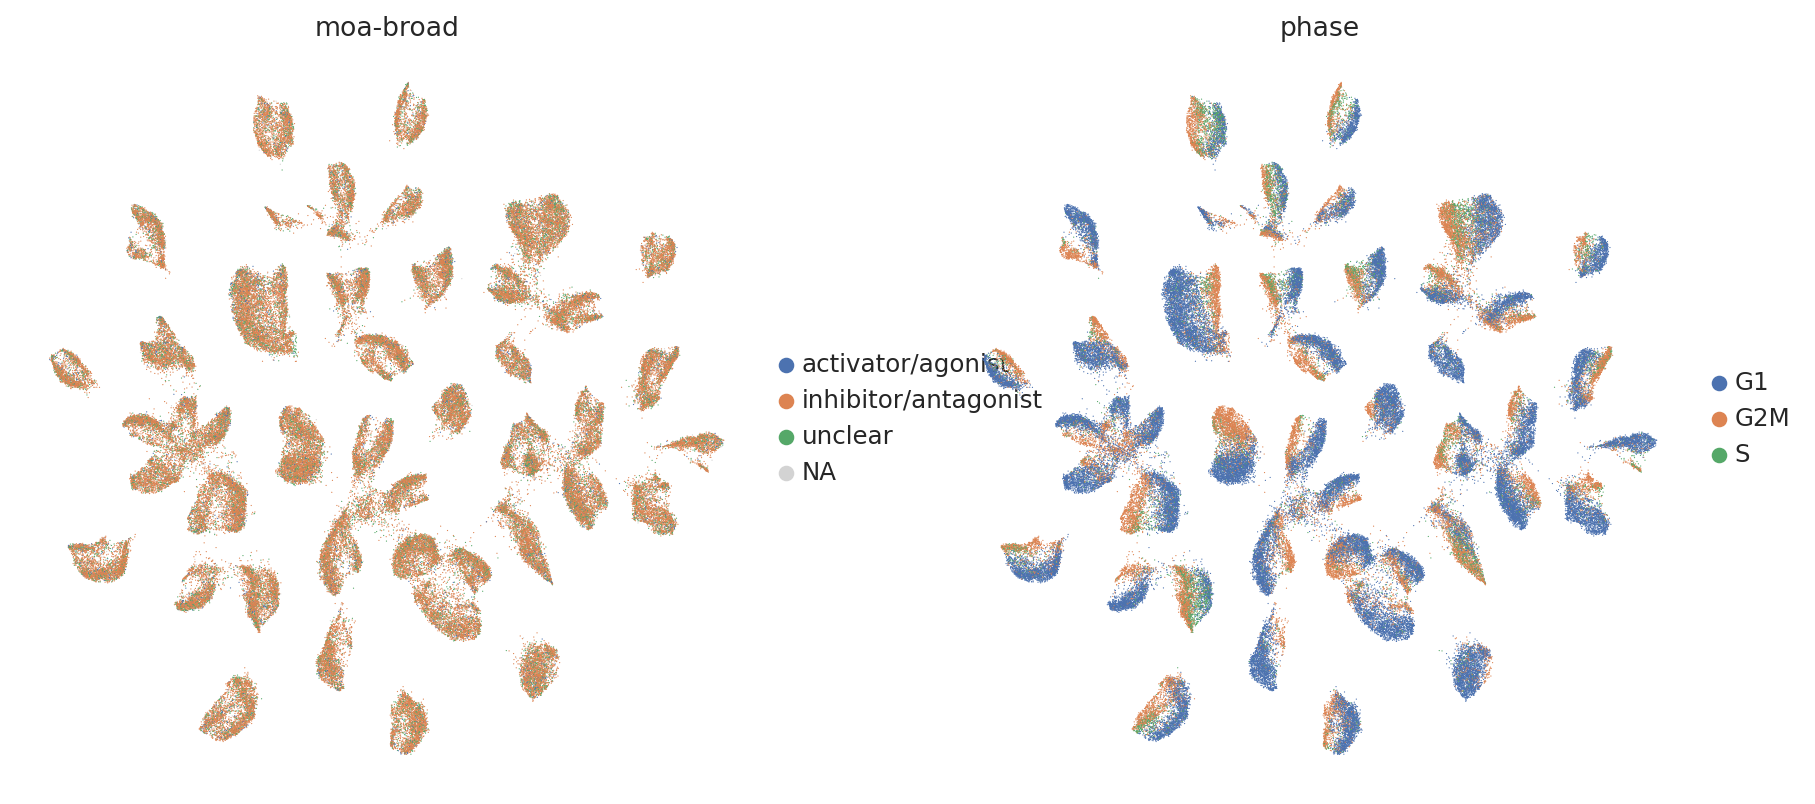

In [39]:
sc.pl.umap(
    adata,
    color=["moa-broad", "phase"],
    frameon=False,
    ncols=2,
)

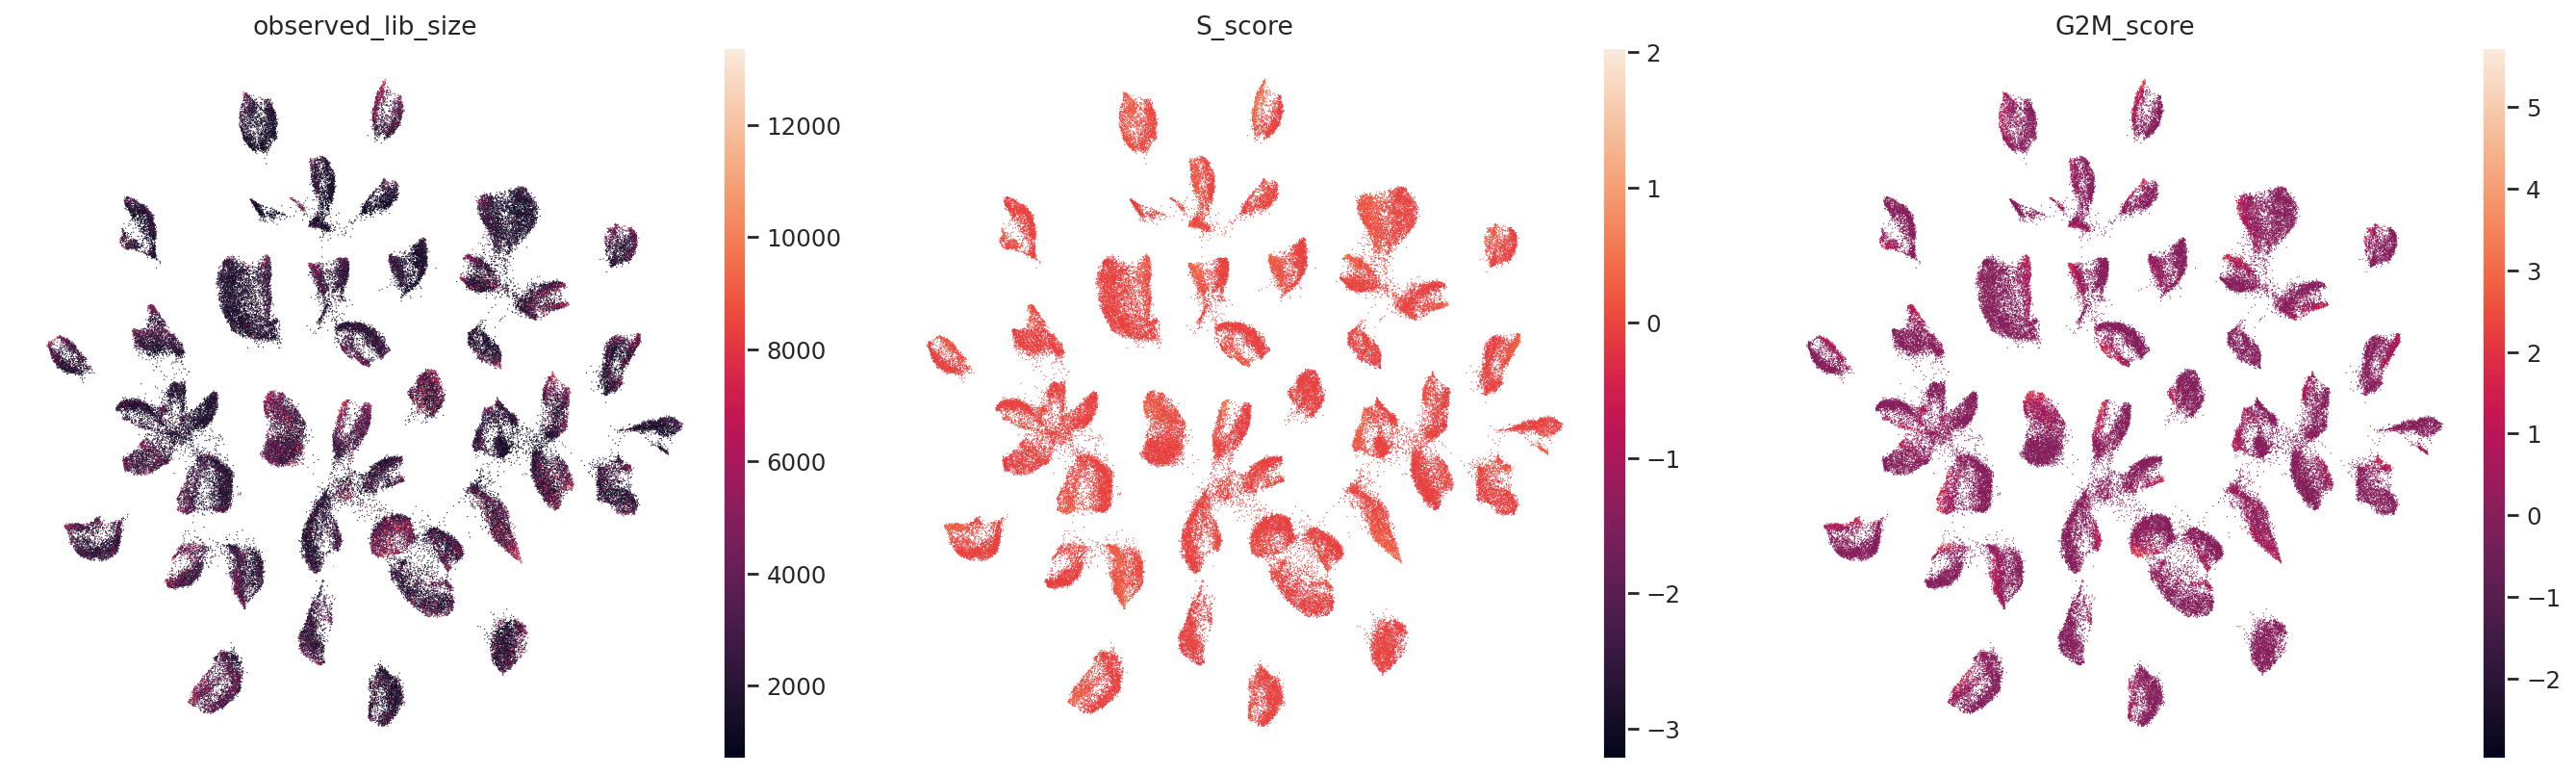

In [40]:
sc.pl.umap(
    adata,
    color=["observed_lib_size", "S_score", "G2M_score"],
    frameon=False,
    ncols=3,
)

## Compare results

In [41]:
from scib_metrics.benchmark import BatchCorrection, Benchmarker, BioConservation

In [ ]:
bm = Benchmarker(
    adata[list(np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)), :],
    batch_key="plate",
    bio_conservation_metrics=BioConservation(
        isolated_labels=True,
        nmi_ari_cluster_labels_leiden=True,
        silhouette_label=True,
        clisi_knn=True,
        nmi_ari_cluster_labels_kmeans=True,
    ),
    batch_correction_metrics=BatchCorrection(
        bras=True,
        pcr_comparison=True,
        kbet_per_label=True,
        graph_connectivity=False,
        ilisi_knn=True,
    ),
    label_key="cell_line_id",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_mrVI_Torch"],
    n_jobs=-1,
)
bm.benchmark()

/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/home/access/.conda/envs/scvi/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
rics:   0%|                                                               | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

In [ ]:
bm.plot_results_table(min_max_scale=False)